In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('../Desktop/Folder/cs_tag_monthly_weekly_daily_with_id.csv')


In [23]:
#df.rename(columns={'date':'period'},inplace=True)

In [3]:
df['period'] = pd.to_datetime(df['period'])

In [4]:
tag = pd.DataFrame(df.groupby('cs_tag')['tag_count'].sum().sort_values(ascending=False)).reset_index()

In [5]:
lst = tag['cs_tag'].head(20).tolist()

In [6]:
df.head()

,period,cs_tag,tag_count
0,2024-01-01,reverification,818
1,2024-01-01,pos/e_commerce,620
2,2024-01-01,direct_debit,582
3,2024-01-01,kyc_issue,447
4,2024-01-01,chargeback,430


In [7]:
df = df[df['cs_tag'].isin(lst)]

In [8]:
df = df.pivot_table('tag_count',['period'],'cs_tag')

In [9]:
df = df.fillna(0)

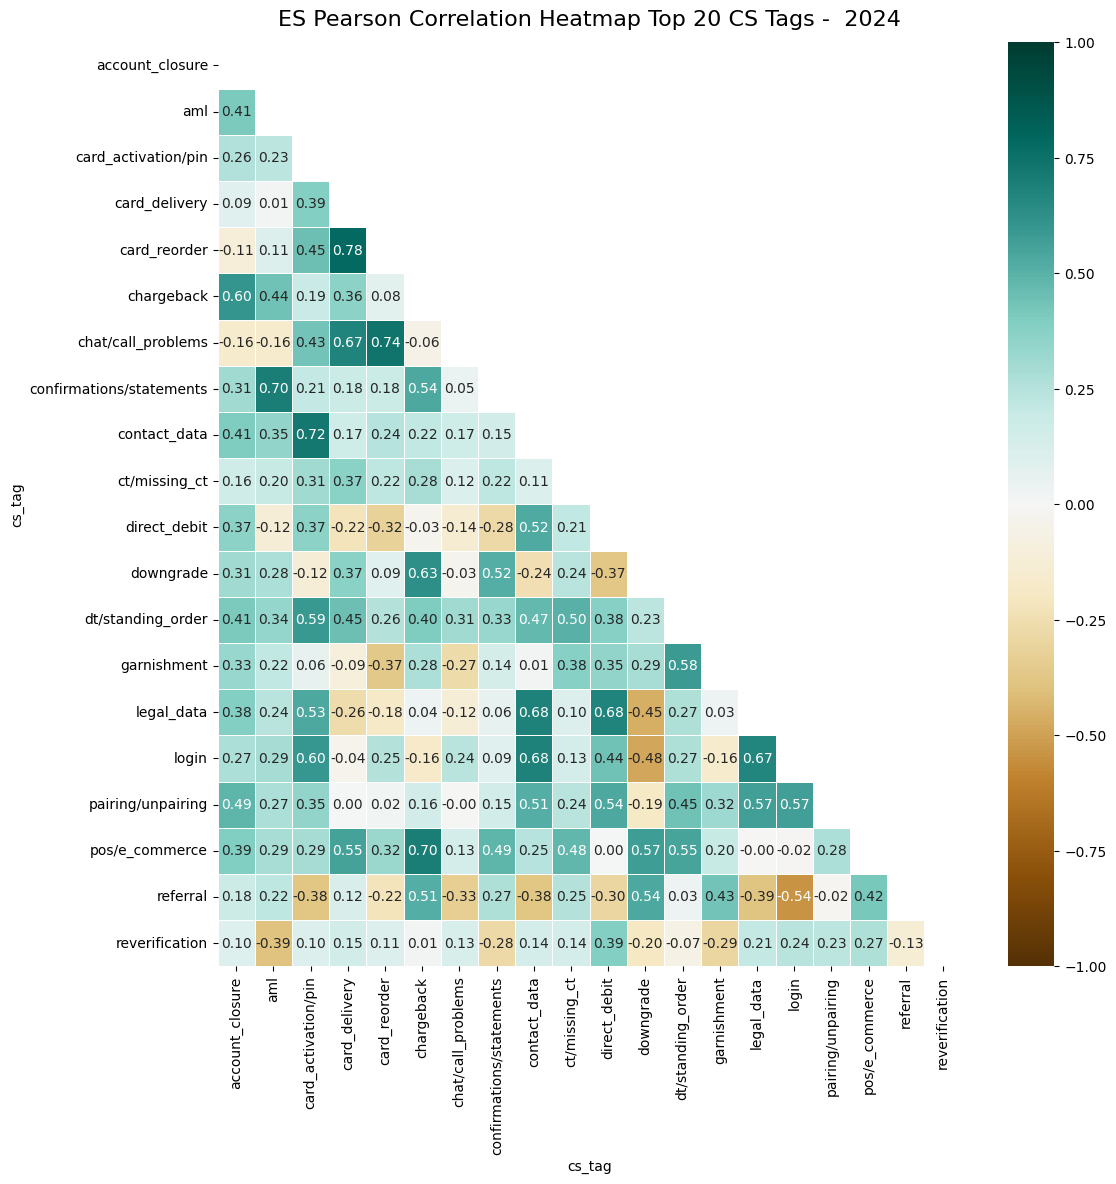

In [10]:
plt.figure(figsize=(12, 12))

matrix = np.triu(df.corr())

heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG', linewidth = .5, mask=matrix, fmt=".2f")
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('ES Pearson Correlation Heatmap Top 20 CS Tags -  2024', fontdict={'fontsize':16}, pad=12)
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

In [12]:
test = df[['referral','downgrade']]
test_1 = test.reset_index()

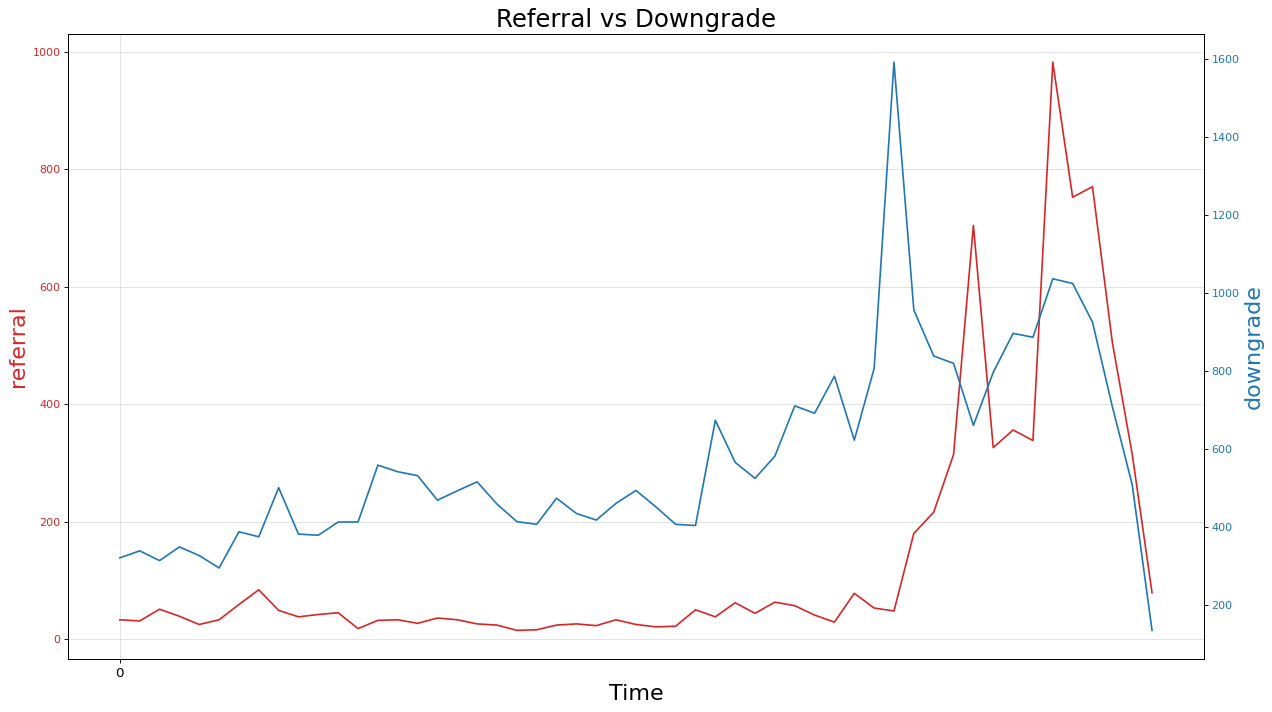

In [13]:
x = test_1.index
y1 = test_1['referral']
y2 = test_1['downgrade']

# Plot Line1 (Left Y Axis)
fig, ax1 = plt.subplots(1,1,figsize=(16,9), dpi= 80)
ax1.plot(x, y1, color='tab:red')

# Plot Line2 (Right Y Axis)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(x, y2, color='tab:blue')

# Decorations
# ax1 (left Y axis)
ax1.set_xlabel('Time', fontsize=20)
ax1.tick_params(axis='x', rotation=0, labelsize=12)
ax1.set_ylabel('referral', color='tab:red', fontsize=20)
ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' )
ax1.grid(alpha=.4)

# ax2 (right Y axis)
ax2.set_ylabel("downgrade", color='tab:blue', fontsize=20)
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.set_xticks(np.arange(0, len(x), 60))
ax2.set_xticklabels(x[::60], rotation=90, fontdict={'fontsize':10})
ax2.set_title("Referral vs Downgrade", fontsize=22)
fig.tight_layout()
plt.show()

### Granger Test

In [14]:
test = df[['referral','downgrade']]

In [31]:
granger_result = grangercausalitytests(test, maxlag=[5], verbose=True)


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.5894  , p=0.0096  , df_denom=37, df_num=5
ssr based chi2 test:   chi2=23.2824 , p=0.0003  , df=5
likelihood ratio test: chi2=18.9815 , p=0.0019  , df=5
parameter F test:         F=3.5894  , p=0.0096  , df_denom=37, df_num=5


In [20]:
def grangers_causation_matrix(data, maxlag, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [32]:
grangers_causation_matrix(data=test, maxlag=4, variables = test.columns)  

,referral_x,downgrade_x
referral_y,1.0000,0.0028
downgrade_y,0.0847,1.0000


<Figure size 1200x1200 with 0 Axes>

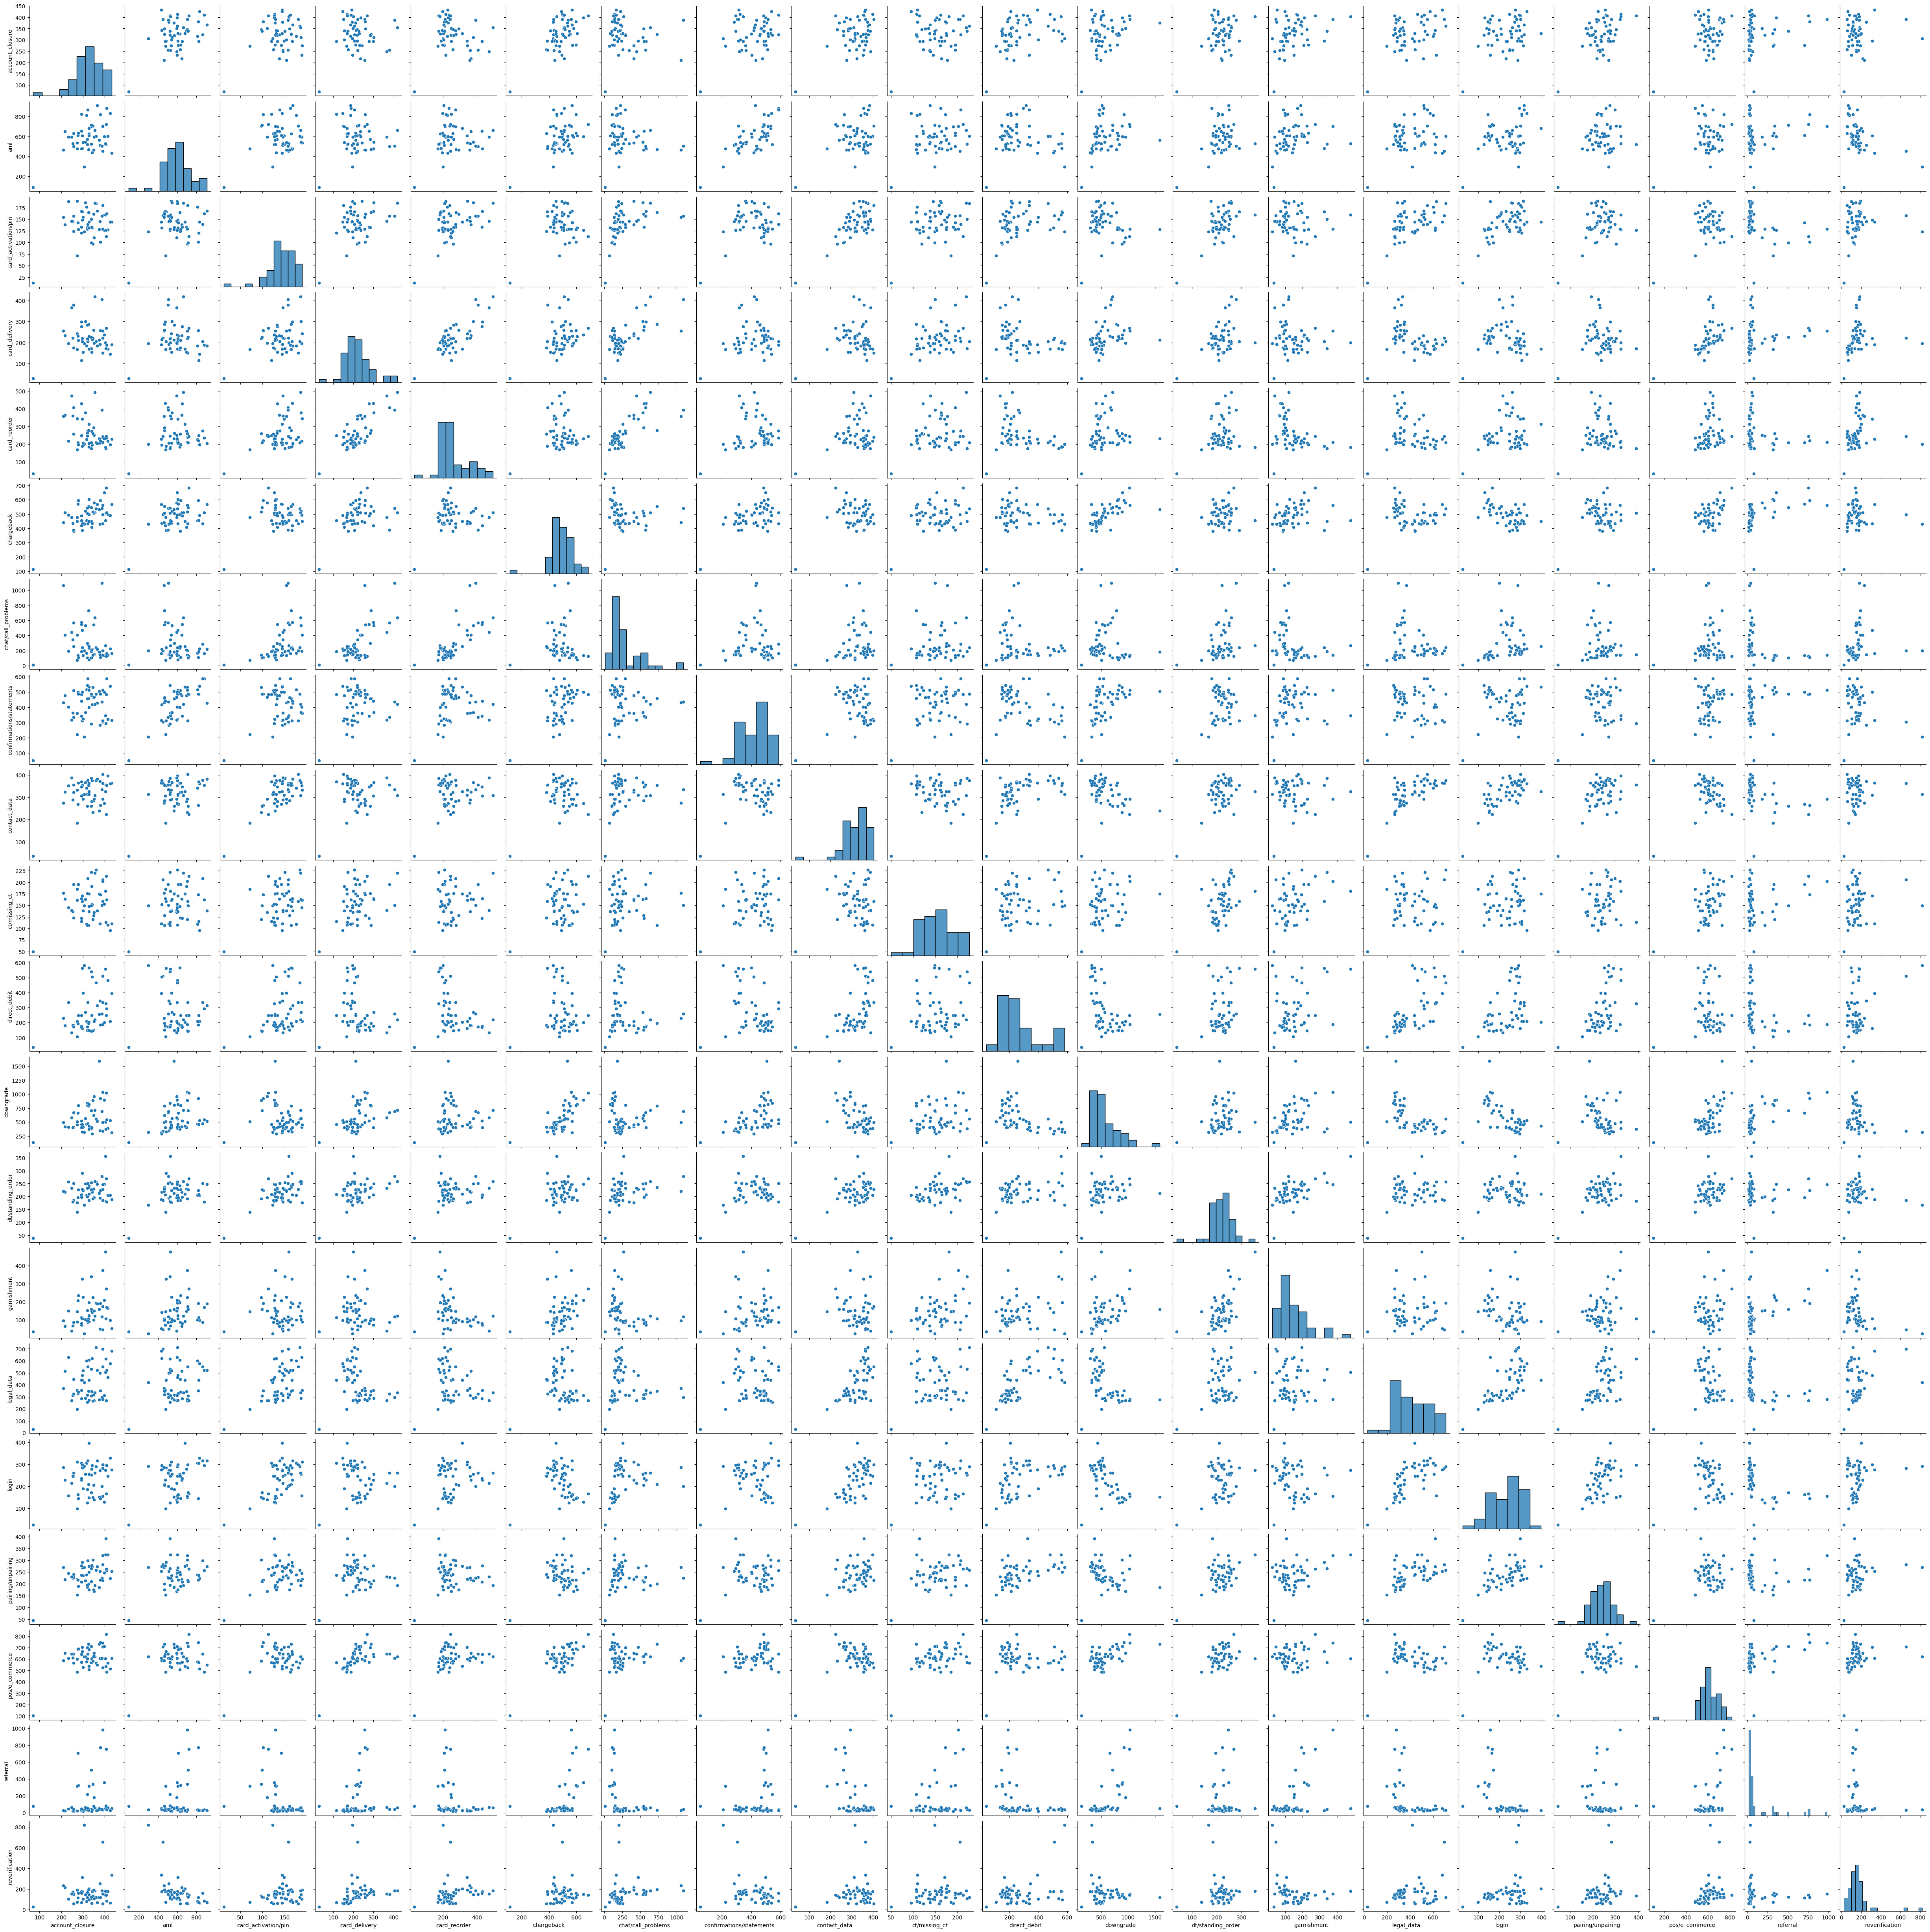

In [101]:
plt.figure(figsize=(12, 12))
sns.pairplot(df, height=2.5)
plt.savefig('pairplot.png', dpi=300, bbox_inches='tight')